In [41]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
import numpy as np
with open('results/text_embeddings_2ch_gr.npy', 'rb') as f:
    texts_embeds_aug = np.load(f)
    
import numpy as np
with open('results/image_embeddings_2ch_gr.npy', 'rb') as f:
    images_embeds_aug = np.load(f)
    

In [44]:
my_file = open("results/names_2ch_gr.txt", "r")
  
# reading the file
names_raw = my_file.read().split('\n')

In [56]:
import json
with open('names_dict.json', 'r') as f:
    names_d = json.loads(f.read())
names_d_inv = dict(zip(names_d.values(), names_d.keys()))

In [57]:
names_raw = [names_raw[i] for i in range(len(names_raw)) if names_raw[i]!='']
names_raw = [names_d_inv[str(int(float(names_raw[i])))] for i in range(len(names_raw))]

In [70]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE()
X_embedded = tsne.fit_transform(images_embeds_aug)


In [71]:
cluster_model = AgglomerativeClustering(affinity = 'cosine', linkage = 'complete', n_clusters=4
                                       )

labels = cluster_model.fit_predict(images_embeds_aug)


/data/proskuryakova/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

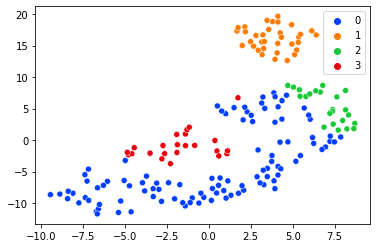

In [72]:
palette = sns.color_palette("bright", 4)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full', palette = palette)


In [121]:
from scipy import spatial
def top_5_similar(embeds1, embeds2):
    sims_img = []
    for i in range(embeds1.shape[0]):
        sim_i = []
        for j in range(embeds2.shape[0]):
            sim_i.append(spatial.distance.cosine(embeds1[i], 
                                                 embeds2[j]))
        sims_img.append(sim_i)
        
    top_5_img = [sorted(sims_img[i], reverse = False)[:6] for i in range(len(sims_img))]
    ind_top5_img = []
    for i in range(len(top_5_img)):
        ind_i = []
        for j in range(len(sims_img[i])):
            if sims_img[i][j] in top_5_img[i]:
                ind_i.append(j)
        ind_top5_img.append([i,ind_i])
    return ind_top5_img

In [123]:
def acc_at_k(sims, k = 5):
    cnt = 0
    for i in range(len(sims)):
        if sims[i][0] in sims[i][1][:k]:
            cnt += 1
    return cnt/len(sims)
    

In [124]:
top5 = top_5_similar(images_embeds_aug, texts_embeds_aug)
acc_at_k(top5)


0.8260869565217391

In [126]:
acc_at_k(top5, k=1), acc_at_k(top5, k=3)

(0.17391304347826086, 0.532608695652174)

In [65]:
import re
divided = True
diagnoses = []
for i in range(len(names_raw)):
    text_path = '/data/burenko/datasets/pet-ct' + '/' + names_raw[i] + '.txt.txt'
    with open(text_path) as f:
        text = f.read().rstrip().replace('\n', ' ')
        text = re.sub( r'[\(\)]', '', text).replace('  ', ' ')

    titles = ['Пол:', '{}.*?{}'.format('Область головы', 'шеи:'),
    'Органы грудной клетки:', 'Органы брюшной полости:', 'Органы малого таза:',
    'Костная система:', 'Диагноз по МКБ-10:']
    last_title = 'Выполнение диагностической услуги:'

    if divided:
        divided_text = []
        for j in range(len(titles)):
            if j < len(titles)-1:

                pat = re.compile('{}(.*){}'.format(titles[j], titles[j+1]))
            else:
                pat = re.compile('{}(.*){}'.format(titles[j], last_title))
            sent = pat.findall(text)
            divided_text.append(''.join(sent).strip())
    diagnoses.append(divided_text[2])


In [66]:
diagnoses[0]

'В области корня правого легкого определяется объемное образование неправильной формы, суживающее просветы долевых и сегментарных бронхов размерами 48х40х70мм, активно накапливающее ФДГ, SUVmax=9,62. Отмечаются метаболически активные лимфатические узлы: -бифуркационные максимальным размером 35х26 мм, $У\\Мтах=9,62. -паравазально максимальным размером 26х26 мм, $\\\\/тах=7,06. -надключичные максимальные размеры до 25х16 мм, 5У\\тах=11,13 -подключичные размерами 17x26mm, SUVmax=10,97 -подмышечные размерами 15х23мм, $У\\тах=7,41. В перикардиальной полости определяется наличие выпота, толщиной до 30 мм. В плевральных полостях определяется свободная жидкость: толщиной справа до 55 мм, слева до 25 мм. Отмечаются метаболически активные очаги литического характера в рукоятке и теле грудины, размерами 25х18 мм, SUVmax=9,94 и 16х19мм, $У\\/тах=9,94. Также отмечаются множественные очаги гиперфиксации в шейных, грудных и поясничных телах позвонков $У\\Мтах=9,04. Определяются метастатические очаги 

In [128]:
diagnoses[12]

'В над- и подключичной области с 2-х сторон л/узлы не увеличены. В верхней доле левого легкого определяется объемное образование неправильной формы, с участками распада, прорастающее междолевую плевру, размерами 61х72х82мм, активно накапливающее РФП, $/\\Мтах=19,70. В базальных отделах правого легкого субплеврально определяется очаговое образование, размерами 8,5х10мм, без наличия метаболической активности, вероятно вторичной природы. Также отмечаются метаболически активные лимфатические узлы: - Паратрахеальные размерами 16х17мм, 5/\\Утах=9,40 - паравазальные размерами 13х8мм, $У\\Утах=7,87 - корня левого легкого размерами 13х13мм, 5/\\тах=12,74 Средостение не смещено и не расширено. В плевральных полостях и полости перикарда экссудата нет.'